In [91]:
import pandas as pd
import math
import numpy as np
import json

from pathlib import Path
import scipy.stats as st

In [92]:
# Collect predictions

def check_num_epochs(run):
    if Path(run / "val_log.csv").is_file():
        with open(run / 'config.json') as f:
            cfg = json.load(f)

        num_epochs = cfg['num_epochs']
        val_iter = cfg['validate_iter']
        num_epochs = int(num_epochs / val_iter)

        valid_log = pd.read_csv(run / "val_log.csv", header=None, index_col=0)
        if (len(valid_log.index)-1) < num_epochs:
            print("Wrong number of epochs in run: {}".format(run))
    else:
        print("val_log.csv not exists in run: {}".format(run))

def check_only_one_tensorboard(run):
    if len(list(Path(run / "runs").glob('*'))) > 1:
        print("More than 1 tensorboard folder in run: {}".format(run))

def collect_one(model_name, run, csv_file):
    check_num_epochs(run)
    check_only_one_tensorboard(run)
    
    with open(run / 'config.json') as f:
        cfg = json.load(f)

    run_number = cfg['seed']
    regime, inv_temp = float(run.parent.parts[-1].rsplit('-', 1)[1]), float(run.parent.parts[-2].rsplit('-', 1)[1])

    csv_path = run / csv_file
    if not csv_path.exists():
        print(f'Skipping not found: {csv_path}')
        return pd.DataFrame()
    
    data = pd.read_csv(csv_path)
    if data.empty:
        print(f'Pred file is empty: {csv_path}')

    data['model'] = model_name
    data['run_number'] = int(run_number)
    data['inv_temp'] = int(inv_temp)
    data['regime'] = int(regime)
    
    return data

def collect_all(model_name, root, csv_file, regimes=['1', '2', '5', '10', '20','100'], ignore_outliers=False):
    root = Path(root)

    metrics = []
    for inv_temp in list(root.glob("inv_temp-*")):
        for regime in list(inv_temp.glob("regime-*")):
            if regime.name.rsplit("-", 1)[1] in regimes:
                for run in list(regime.glob("run-*")):
                    if not ignore_outliers and 'outlier' in run.as_posix():
                        continue
                    else:
                        metrics.append(collect_one(model_name, run, csv_file))
        
    metrics = pd.concat(metrics, ignore_index=True)
    
    return metrics

In [93]:
# Compute metrics for each detected run

def compute_metrics(data, grouping, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance']):
    metrics_dict_names = {
        'Dice': 'dice',
        'Jaccard': 'jaccard',
        'Hausdorff Distance': '95hd',
        'Average Surface Distance': 'asd'
    }

    columns = ['Model', '# Run', 'Inv Temp', 'Regime']
    columns.extend(metric_names)
    metrics = []
    
    data = data.copy().reset_index()
    grouped = data.groupby(grouping)
    
    for model_group, predictions in grouped:
        model_name, run_number, inv_temp, regime = model_group[0], int(model_group[1]), int(model_group[2]), int(model_group[3])
        
        metric_values = []
        for metric_name in metric_names:
            values = predictions['segm/{}'.format(metrics_dict_names[metric_name])].values
            mean_value = np.nanmean(values)
            if metric_name == 'Dice' or metric_name == 'Jaccard':
                metric_values.append((math.ceil(mean_value*10000)/10000)*100)
            else:
                if not np.isnan(mean_value):
                    metric_values.append(math.ceil(mean_value*100)/100)
                else:
                    metric_values.append(mean_value)
        
        metrics.append([model_name, run_number, inv_temp, regime, *metric_values])
        
    metrics_df = pd.DataFrame(metrics, columns=columns)
    
    return metrics_df

def summarize_metrics(metrics, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'], confidence_level=0.90, return_ranges=False):

    def compute_ci(values, return_ranges=False):
        ci = st.t.interval(confidence_level, len(values)-1, loc=np.mean(values), scale=np.std(values)/(len(values)**0.5))

        if return_ranges:
            return ci
        else:
            return (ci[1]-ci[0]) / 2

    #mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', np.mean), ('STD', np.std), ("CI {}%".format(confidence_level), compute_ci)])
    mean_metrics = metrics.groupby(['Model', 'Inv Temp', 'Regime'])[metric_names].aggregate([('Mean', 'mean'), ("CI {}%".format(confidence_level), compute_ci)]) 

    return mean_metrics

<h1>Atrial Dataset</h1>

<h2>Evaluation - Data regime variations</h2>

In [105]:
EXP_ROOT = "/home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs"

REGIMES = ['1', '2', '5', '10', '20']

runs = {
    #'UNet3D': list(Path(EXP_ROOT + '/Atrial/semi_sup/').glob('kaiming_unet3d')),
    'EM-UNet3D': list(Path(EXP_ROOT + '/Atrial/semi_sup/').glob('em_unet3d')),
    'CPS-UNet3D': list(Path(EXP_ROOT + '/Atrial/semi_sup/').glob('cps_unet3d')),
    'UAMT-UNet3D': list(Path(EXP_ROOT + '/Atrial/semi_sup/').glob('uamt_unet3d')),
    'URPC-UNet3D': list(Path(EXP_ROOT + '/Atrial/semi_sup/').glob('urpc_unet3d')),
    'CCT-UNet3D': list(Path(EXP_ROOT + '/Atrial/semi_sup/').glob('cct_unet3d')),
    'DTC-UNet3D': list(Path(EXP_ROOT + '/Atrial/semi_sup/').glob('dtc_unet3d')),
}

In [106]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'test.csv', regimes=REGIMES, ignore_outliers=True) for k, v in runs.items() for r in v], ignore_index=True)

In [107]:
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'])

display(metrics)

summary = summarize_metrics(metrics, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'], confidence_level=0.90)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,CCT-UNet3D,0,1,1,64.70,47.82,40.25,9.29
1,CCT-UNet3D,0,1,2,78.48,64.59,27.48,6.20
2,CCT-UNet3D,0,1,5,85.54,74.73,16.81,3.75
3,CCT-UNet3D,0,1,10,87.20,77.29,12.68,2.97
4,CCT-UNet3D,0,1,20,90.93,83.36,6.46,1.85
...,...,...,...,...,...,...,...,...
145,URPC-UNet3D,4,1,1,67.72,51.19,36.35,8.97
146,URPC-UNet3D,4,1,2,79.69,66.23,26.39,6.00
147,URPC-UNet3D,4,1,5,82.72,70.53,24.45,4.91
148,URPC-UNet3D,4,1,10,88.19,78.88,13.17,2.98


Dice           Jaccard            \
                               Mean   CI 0.9%    Mean   CI 0.9%   
Model       Inv Temp Regime                                       
CCT-UNet3D  1        1       62.932  6.055446  46.226  6.404382   
                     2       78.636  2.741297  64.886  3.720798   
                     5       85.110  0.497776  74.080  0.753239   
                     10      88.804  1.070885  79.872  1.739779   
                     20      90.742  0.522590  83.052  0.867227   
CPS-UNet3D  1        1       71.700  8.420666  56.582  9.658514   
                     2       84.684  1.498633  73.466  2.248075   
                     5       88.238  0.819792  78.958  1.307201   
                     10      89.724  0.593790  81.364  0.976108   
                     20      90.740  0.485949  83.050  0.810976   
DTC-UNet3D  1        1       67.118  5.708923  50.814  6.505040   
                     2       79.100  3.283803  65.558  4.428413   
                     5       83.828  2.393231  72.234  3.494640   
                     10      86.814  1.451493  76.728  2.256259   
                     20      90.084  0.552394  81.954  0.912701   
EM-UNet3D   1        1       67.390  4.542489  51.016  5.258386   
                     2       76.226  4.812468  61.846  6.077352   
                     5       83.154  3.202420  71.304  4.677229   
                     10      87.416  1.655978  77.684  2.600382   
                     20      89.692  0.246514  81.310  0.404939   
UAMT-UNet3D 1        1       62.726  5.500682  45.952  5.896447   
                     2       76.162  4.559950  61.730  5.776749   
                     5       85.826  2.479708  75.258  3.737712   
                     10      89.482  0.425789  80.964  0.695873   
                     20      91.098  0.190048  83.646  0.319783   
URPC-UNet3D 1        1       71.254  3.943557  55.508  4.747980   
                     2       77.536  2.317604  63.378  3.045903   
                     5       83.262  1.270186  71.344  1.869187   
                     10      86.846  0.684893  76.754  1.080989   
                     20      89.130  0.284998  80.384  0.460818   

                            Hausdorff Distance            \
                                          Mean   CI 0.9%   
Model       Inv Temp Regime                                
CCT-UNet3D  1        1                  37.858  4.935746   
                     2                  26.804  5.426121   
                     5                  16.654  2.338018   
                     10                 11.070  2.627930   
                     20                  7.616  2.519064   
CPS-UNet3D  1        1                  28.664  9.209096   
                     2                  15.506  2.682609   
                     5                  10.736  1.834494   
                     10                  9.106  1.541319   
                     20                  7.636  1.893153   
DTC-UNet3D  1        1                  32.170  4.525087   
                     2                  21.734  4.871219   
                     5                  16.886  3.039111   
                     10                 12.604  3.833886   
                     20                  7.404  1.151949   
EM-UNet3D   1        1                  33.508  5.254176   
                     2                  27.030  6.874764   
                     5                  20.264  4.206464   
                     10                 14.206  2.949414   
                     20                  9.550  1.326276   
UAMT-UNet3D 1        1                  37.788  6.408130   
                     2                  25.406  8.032515   
                     5                  13.854  2.685725   
                     10                  8.362  0.513218   
                     20                  5.984  0.243262   
URPC-UNet3D 1        1                  34.514  3.926200   
                     2                  27.098  3.223349   
                   

<h2>Evaluation - Unsupervised Pretraining</h2>

In [123]:
EXP_ROOT = "/home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs"

REGIMES = ['100']

runs = {
    #'H-UNet3D-SWTA-T': list(Path(EXP_ROOT + '/Atrial/hebbian_unsup/').glob('unet3d_swta_t')),
    #'H-UNet3D-URPC-SWTA-T': list(Path(EXP_ROOT + '/Atrial/hebbian_unsup/').glob('unet3d_urpc_swta_t')),
    #'H-UNet3D-CCT-SWTA-T': list(Path(EXP_ROOT + '/Atrial/hebbian_unsup/').glob('unet3d_cct_swta_t')),
    #'H-UNet3D-DTC-SWTA-T': list(Path(EXP_ROOT + '/Atrial/hebbian_unsup/').glob('unet3d_dtc_swta_t')),
    ##'VAE-UNet3D': list(Path(EXP_ROOT + '/HMEPS/vae_unsup/').glob('unet_vae')),
    ##'Superpix-UNet': list(Path(EXP_ROOT + '/HMEPS/superpix_unsup/').glob('unet_superpix')),
}

In [124]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'test.csv', regimes=REGIMES, ignore_outliers=False) for k, v in runs.items() for r in v], ignore_index=True)

Skipping not found: /home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs/Atrial/hebbian_unsup/unet3d_urpc_swta_t/inv_temp-1/regime-100/run-0/test.csv
Skipping not found: /home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs/Atrial/hebbian_unsup/unet3d_urpc_swta_t/inv_temp-20/regime-100/run-0/test.csv
Skipping not found: /home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs/Atrial/hebbian_unsup/unet3d_urpc_swta_t/inv_temp-5/regime-100/run-0/test.csv
Skipping not found: /home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs/Atrial/hebbian_unsup/unet3d_urpc_swta_t/inv_temp-50/regime-100/run-0/test.csv
Skipping not found: /home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs/Atrial/hebbian_unsup/unet3d_urpc_swta_t/inv_temp-75/regime-100/run-0/test.csv


In [122]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'])

display(metrics)

summary = summarize_metrics(metrics, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'], confidence_level=0.90)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-UNet3D-SWTA-T,0,1,100,32.01,19.06,47.08,14.77
1,H-UNet3D-SWTA-T,0,5,100,17.96,9.87,61.02,32.14
2,H-UNet3D-SWTA-T,0,10,100,18.79,10.37,60.24,29.30
3,H-UNet3D-SWTA-T,0,20,100,18.33,10.09,60.17,28.34
4,H-UNet3D-SWTA-T,0,50,100,26.60,15.34,51.75,12.63
5,H-UNet3D-SWTA-T,0,75,100,20.24,11.26,56.81,17.54
6,H-UNet3D-SWTA-T,0,100,100,20.21,11.24,57.26,18.07


/home/luca/anaconda3/envs/xnet/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2244: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/luca/anaconda3/envs/xnet/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2245: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Dice         Jaccard          \
                                  Mean CI 0.9%    Mean CI 0.9%   
Model           Inv Temp Regime                                  
H-UNet3D-SWTA-T 1        100     32.01     NaN   19.06     NaN   
                5        100     17.96     NaN    9.87     NaN   
                10       100     18.79     NaN   10.37     NaN   
                20       100     18.33     NaN   10.09     NaN   
                50       100     26.60     NaN   15.34     NaN   
                75       100     20.24     NaN   11.26     NaN   
                100      100     20.21     NaN   11.24     NaN   

                                Hausdorff Distance          \
                                              Mean CI 0.9%   
Model           Inv Temp Regime                              
H-UNet3D-SWTA-T 1        100                 47.08     NaN   
                5        100                 61.02     NaN   
                10       100                 60.24     NaN   
                20       100                 60.17     NaN   
                50       100                 51.75     NaN   
                75       100                 56.81     NaN   
                100      100                 57.26     NaN   

                                Average Surface Distance          
                                                    Mean CI 0.9%  
Model           Inv Temp Regime                                   
H-UNet3D-SWTA-T 1        100                       14.77     NaN  
                5        100                       32.14     NaN  
                10       100                       29.30     NaN  
                20       100                       28.34     NaN  
                50       100                       12.63     NaN  
                75       100                       17.54     NaN  
                100      100                       18.07     NaN

<h2>Evaluation - Hebbian Models Data Regime Variations</h2>

In [185]:
EXP_ROOT = "/home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs"

REGIMES = ['1', '2', '5', '10', '20']
REGIMES = ['1']

runs = {
    #'H-UNet3D-SWTA-T': list(Path(EXP_ROOT + '/Atrial/semi_sup/').glob('h_unet3d_swta_t')),
    #'H-EM-SWTA-T': list(Path(EXP_ROOT + '/Atrial/semi_sup/').glob('h_em_unet3d_swta_t')),
    #'H-UAMT-SWTA-T': list(Path(EXP_ROOT + '/Atrial/semi_sup/').glob('h_uamt_unet3d_swta_t')),
    #'H-DTC-SWTA-T': list(Path(EXP_ROOT + '/Atrial/semi_sup/').glob('h_dtc_unet3d_swta_t')),
    #'H-CCT-SWTA-T': list(Path(EXP_ROOT + '/Atrial/semi_sup/').glob('h_cct_unet3d_swta_t')),
    #'H-CPS-SWTA-T': list(Path(EXP_ROOT + '/Atrial/semi_sup/').glob('h_cps_unet3d_swta_t')),
    'H-URPC-SWTA-T': list(Path(EXP_ROOT + '/Atrial/semi_sup/').glob('h_urpc_unet3d_swta_t')),
}

In [186]:
# Collect predictions scanning runs
predictions = pd.concat([collect_all(k, r, 'test.csv', regimes=REGIMES, ignore_outliers=True) for k, v in runs.items() for r in v], ignore_index=True)

More than 1 tensorboard folder in run: /home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs/Atrial/semi_sup/h_urpc_unet3d_swta_t/inv_temp-100/regime-1/run-0
Skipping not found: /home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs/Atrial/semi_sup/h_urpc_unet3d_swta_t/inv_temp-100/regime-1/run-0/test.csv
Skipping not found: /home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs/Atrial/semi_sup/h_urpc_unet3d_swta_t/inv_temp-100/regime-1/run-1/test.csv
Skipping not found: /home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs/Atrial/semi_sup/h_urpc_unet3d_swta_t/inv_temp-100/regime-1/run-2/test.csv
Skipping not found: /home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/runs/Atrial/semi_sup/h_urpc_unet3d_swta_t/inv_temp-100/regime-1/run-3/test.csv
Skipping not found: /home/luca/datino/results/hebbian-bootstraping-semi-supervised-medical-imaging/r

In [180]:
# Computing metrics
model_grouper = ['model', 'run_number', 'inv_temp', 'regime']
metrics = compute_metrics(predictions, model_grouper, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'])

display(metrics)

summary = summarize_metrics(metrics, metric_names=['Dice', 'Jaccard', 'Hausdorff Distance', 'Average Surface Distance'], confidence_level=0.90)

display(summary)

,Model,# Run,Inv Temp,Regime,Dice,Jaccard,Hausdorff Distance,Average Surface Distance
0,H-CCT-SWTA-T,0,20,1,71.55,55.70,24.77,7.02
1,H-CCT-SWTA-T,0,50,1,66.14,49.40,32.29,8.89
2,H-CCT-SWTA-T,0,75,1,67.86,51.35,28.83,7.93
3,H-CCT-SWTA-T,0,100,1,69.75,53.55,27.14,7.35
4,H-CCT-SWTA-T,1,20,1,53.19,36.23,46.45,14.72
5,H-CCT-SWTA-T,1,50,1,57.34,40.19,44.37,13.17
6,H-CCT-SWTA-T,1,75,1,56.02,38.91,42.06,13.04
7,H-CCT-SWTA-T,1,100,1,58.33,41.18,44.55,13.06
8,H-CCT-SWTA-T,2,20,1,65.75,48.98,35.18,9.79
9,H-CCT-SWTA-T,2,50,1,61.50,44.40,37.28,10.97


Dice           Jaccard            \
                                Mean   CI 0.9%    Mean   CI 0.9%   
Model        Inv Temp Regime                                       
H-CCT-SWTA-T 20       1       65.478  6.135615  48.996  6.443197   
             50       1       62.628  5.558766  45.854  6.025188   
             75       1       64.270  5.400829  47.606  5.905241   
             100      1       65.952  4.913553  49.422  5.483711   

                             Hausdorff Distance            \
                                           Mean   CI 0.9%   
Model        Inv Temp Regime                                
H-CCT-SWTA-T 20       1                  33.062  7.163562   
             50       1                  36.538  4.962571   
             75       1                  33.820  4.833588   
             100      1                  33.246  6.156386   

                             Average Surface Distance            
                                                 Mean   CI 0.9%  
Model        Inv Temp Regime                                     
H-CCT-SWTA-T 20       1                         9.674  2.547468  
             50       1                        10.816  1.815869  
             75       1                         9.876  1.845865  
             100      1                         9.566  2.045228

<h1>Plots</h1>

In [4]:
import matplotlib.pyplot as plt

<h3>Atrial Dataset</h3>

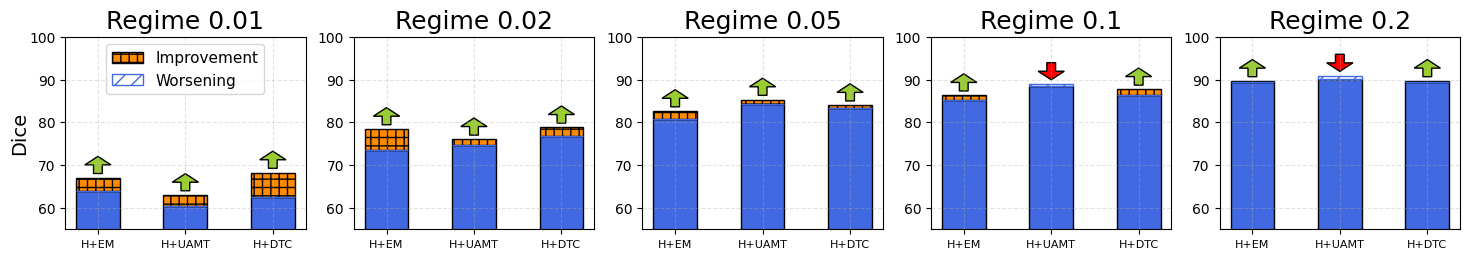

In [90]:
width=0.5

x_labels = ['H+EM', 'H+UAMT', 'H+DTC']
regimes = ['0.01', '0.02', '0.05', '0.1', '0.2']

fig, axes = plt.subplots(1, 5, figsize=(18, 2.5), squeeze=False)

for j in range(5):
    #axes[0][j].xaxis.set_major_locator(ticker.NullLocator())
    #axes[0][j].set_xlabel("Method", fontsize=10)
    axes[0][j].tick_params(axis='x', labelrotation=0)
    axes[0][j].xaxis.set_tick_params(labelsize=8)
    axes[0][j].grid(linestyle='--', linewidth=0.8, alpha=0.35)
    #axes[0][j].set_ylabel("Dice", fontsize=14, labelpad=-5)
    axes[0][j].yaxis.set_tick_params(labelsize=10)
    axes[0][j].set_title('Regime {}'.format(regimes[j]), fontsize=18)
    axes[0][j].set_ylim([55, 100])

axes[0][0].set_ylabel("Dice", fontsize=14, labelpad=0)


############################
# Regime 0.01
values_001 = [64.00, 60.42, 62.63]
improvements_001 = [(67.04-64.00), (63.00-60.42), (68.25-62.63)]
worsening_001 = [0, 0, 0]

axes[0,0].bar(x_labels, values_001, width=width, edgecolor="black", color='royalblue')
axes[0,0].bar(x_labels, improvements_001, bottom=values_001, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,0].bar(x_labels, worsening_001, bottom=values_001, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,0].arrow(x=0, y=67.04+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=2)
axes[0,0].arrow(x=1, y=63.00+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=2)
axes[0,0].arrow(x=2, y=68.25+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=2)
axes[0,0].legend(ncol=1, fontsize=11, loc='upper center')

############################
# Regime 0.02
values_002 = [73.53, 74.80, 76.87]
improvements_002 = [(78.43-73.53), (76.01-74.80), (78.82-76.87)]
worsening_002 = [0, 0, 0]

axes[0,1].bar(x_labels, values_002, width=width, edgecolor="black", color='royalblue')
axes[0,1].bar(x_labels, improvements_002, bottom=values_002, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,1].bar(x_labels, worsening_002, bottom=values_002, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,1].arrow(x=0, y=78.43+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=2)
axes[0,1].arrow(x=1, y=76.01+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=2)
axes[0,1].arrow(x=2, y=78.82+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=2)
#axes[1,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.05
values_005 = [80.80, 84.22, 83.28]
improvements_005 = [(82.62-80.80), (85.31-84.22), (84.00-83.28)]
worsening_005 = [0, 0, 0]

axes[0,2].bar(x_labels, values_005, width=width, edgecolor="black", color='royalblue')
axes[0,2].bar(x_labels, improvements_005, bottom=values_005, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,2].bar(x_labels, worsening_005, bottom=values_005, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,2].arrow(x=0, y=82.62+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=2)
axes[0,2].arrow(x=1, y=85.31+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=2)
axes[0,2].arrow(x=2, y=84.00+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=2)
#axes[0,2].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.1
values_01 = [85.33, 88.95-(88.95-88.47), 86.43]
improvements_01 = [(86.33-85.33), 0, (87.69-86.43)]
worsening_01 = [0, (88.95-88.47), 0]

axes[0,3].bar(x_labels, values_01, width=width, edgecolor="black", color='royalblue')
axes[0,3].bar(x_labels, improvements_01, bottom=values_01, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,3].bar(x_labels, worsening_01, bottom=values_01, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,3].arrow(x=0, y=86.33+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=2)
axes[0,3].arrow(x=1, y=88.95+1+2+2, dx=0, dy=-2, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=2)
axes[0,3].arrow(x=2, y=87.69+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=2)
#axes[3,0].legend(ncol=2, fontsize=12, loc='lower center')

############################
# Regime 0.2
values_02 = [89.51, 90.91-(90.91-90.23), 89.46]
improvements_02 = [(89.67-89.51), 0, (89.67-89.46)]
worsening_02 = [0, (90.91-90.23), 0]

axes[0,4].bar(x_labels, values_02, width=width, edgecolor="black", color='royalblue')
axes[0,4].bar(x_labels, improvements_02, bottom=values_02, width=width, edgecolor="black", color='darkorange', label='Improvement', hatch="++")
axes[0,4].bar(x_labels, worsening_02, bottom=values_02, width=width, edgecolor="royalblue", color='white', label='Worsening', hatch="//")
axes[0,4].arrow(x=0, y=89.67+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=2)
axes[0,4].arrow(x=1, y=90.91+1+2+2, dx=0, dy=-2, width=.1, facecolor='red', edgecolor='black', head_width=0.3, head_length=2)
axes[0,4].arrow(x=2, y=89.67+1, dx=0, dy=2, width=.1, facecolor='yellowgreen', edgecolor='black', head_width=0.3, head_length=2)
#axes[4,0].legend(ncol=2, fontsize=12, loc='lower center')

#plt.tight_layout()
plt.subplots_adjust(wspace=.2, hspace=.1)
plt.savefig("./figures/atrial_plots_h.pdf", format="pdf", bbox_inches="tight")
plt.show()